In [1]:
import numpy as np
from osgeo import gdal
import ogr
from skimage import exposure
from skimage.segmentation import felzenszwalb, mark_boundaries
import geopandas as gpd
import numpy as np
import torch
import os
import scipy
from helper import *
from skimage.util import img_as_float
import imageio
from skimage.measure import regionprops_table
from scipy.stats import mode
from skimage.color import label2rgb, rgb2gray
from skimage import color, feature, measure
from scipy.ndimage import find_objects
from skimage.measure import regionprops, perimeter
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# def set_random_seed(seed_value):
#     """Set seed for reproducibility."""
#     torch.manual_seed(seed_value)  # PyTorch random seed
#     torch.cuda.manual_seed_all(seed_value)  # CUDA random seed for all GPUs
#     np.random.seed(seed_value)  # Numpy random seed
#     random.seed(seed_value)  # Python random seed
#     torch.backends.cudnn.deterministic = True  # Ensures deterministic algorithm is used
#     torch.backends.cudnn.benchmark = False  # True can speed up training but might make experiments less reproducible

# # Example usage
# seed_value = 1
# set_random_seed(seed_value)

In [3]:
data_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/nz-cattle/nz-cattle-rgb-label'

In [4]:
image = '001_Hamilton_(2016-2017)_175.28054388784528,-37.83036803544756_image.png'
label = '001_Hamilton_(2016-2017)_175.28054388784528,-37.83036803544756_label.png'
image_path = os.path.join(data_dir, image)
labels_map_path = os.path.join(data_dir, label)

In [5]:
image = imageio.v2.imread(image_path)
labels_map = imageio.v2.imread(labels_map_path)
assert image.shape[:2] == labels_map.shape[:2]
segments = felzenszwalb(image, scale=4000, sigma=0.5, min_size=10)

# Initialize an array to hold the label for each superpixel
superpixel_labels = np.zeros_like(segments)

# Create a dictionary to store superpixel labels
superpixel_label_dict = {} 

# Iterate over each superpixel and assign labels based on the majority vote from the mask
for superpixel_id in np.unique(segments):
    # Find all pixels belonging to the current superpixel
    superpixel_mask = segments == superpixel_id
    indices = np.where(superpixel_mask)
    
    # Extract corresponding labels from the label mask
    labels_within_superpixel = labels_map[superpixel_mask]
    
    # Determine the most common label within this superpixel
    # The mode function returns both the most common value and its count, we only need the value
    dominant_label = np.bincount(labels_within_superpixel).argmax() # = mode(labels_for_segment)[0][0]
    
    # Store the label for the superpixel
    superpixel_label_dict[superpixel_id] = {
        'dominant_label': dominant_label,
        'indices': indices  # Stores (y, x) coordinates 
    }

    # Assign this label to the superpixel in the result
    superpixel_labels[superpixel_mask] = dominant_label

superpixel_image = label2rgb(superpixel_labels, image, kind='overlay') 


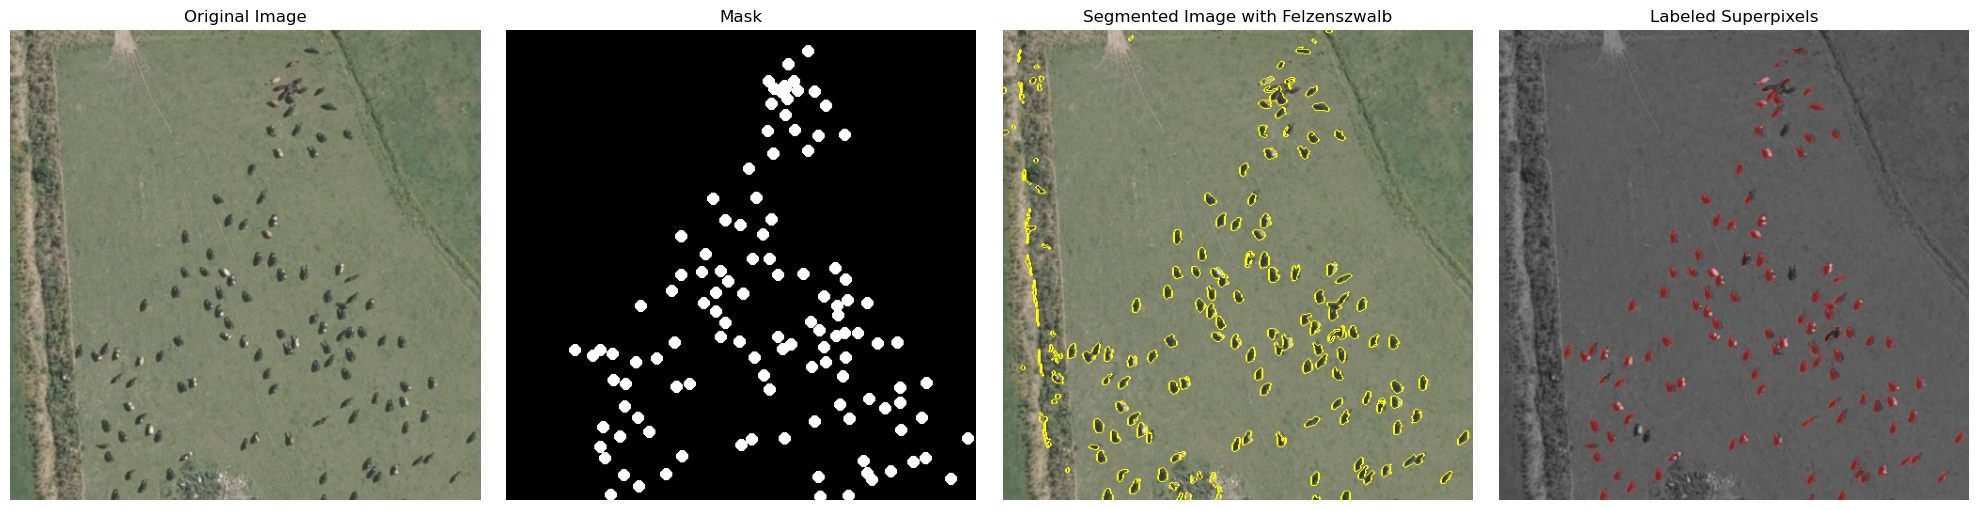

In [6]:
# Create a figure to hold the subplots
plt.figure(figsize=(20, 5))  # Adjusted figsize for a 2x2 grid

# Plot the first image - Original Image
plt.subplot(1, 4, 1)  # 2 rows, 2 columns, first subplot
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')  # Hide the axis for a cleaner look

# Plot the second image - Mask
plt.subplot(1, 4, 2)  # 2 rows, 2 columns, second subplot
plt.imshow(labels_map, cmap='gray')
plt.title('Mask')
plt.axis('off')

# Plot the third image - Segmented Image with Boundaries
plt.subplot(1, 4, 3)  # 2 rows, 2 columns, third subplot
plt.imshow(mark_boundaries(image, segments))
plt.title('Segmented Image with Felzenszwalb')
plt.axis('off')

# Plot the fourth image - Labeled Superpixels
plt.subplot(1, 4, 4)  # 2 rows, 2 columns, fourth subplot
# For visualizing the superpixel labels, we can use the `superpixel_labels` as is,
# assuming it's an array where each unique value represents a different label.
plt.imshow(superpixel_image, cmap='nipy_spectral')  # 'nipy_spectral' offers a good range of colors
plt.title('Labeled Superpixels')
plt.axis('off')

# Display the plot
plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()


In [7]:
# Function to calculate texture contrast as the standard deviation of grayscale intensity
def calculate_texture_contrast(grayscale_image, indices):
    return np.std(grayscale_image[indices])

# Convert the image to grayscale for texture analysis
grayscale_image = rgb2gray(image)

# List to store feature data for each superpixel
features_list = []

# Iterate over each superpixel in the dictionary
for superpixel_id, data in superpixel_label_dict.items():
    # Get the dominant label and indices for the current superpixel
    label = data['dominant_label']
    indices = data['indices']
    
    # Create a binary mask for the current superpixel
    superpixel_mask = np.zeros_like(segments, dtype=np.uint8)
    superpixel_mask[indices] = 1

    # Extract the pixel values for the current superpixel
    superpixel_pixels = image[indices]
    
    # Calculate the average and standard deviation of the color
    avg_color = np.mean(superpixel_pixels, axis=0)
    std_color = np.std(superpixel_pixels, axis=0)
    
    # Calculate the area as the number of pixels
    # area = len(superpixel_pixels)  # Equivalent to the next command
    area = superpixel_pixels.shape[0]
    
    # Calculate texture contrast
    texture_contrast = calculate_texture_contrast(grayscale_image, indices)

    # Use regionprops to calculate geometric properties
    props = regionprops(superpixel_mask)[0]  # Only one region in mask
    
    # Calculate fragmentation as perimeter^2 / area
    # fragmentation = perimeter(superpixel_mask)**2 / area if area > 0 else 0
    perimeter = measure.perimeter(superpixel_mask, neighborhood=2)
    fragmentation = perimeter / float(area) if area > 0 else 0
    
    # Add the feature data for the current superpixel to the list
    features_list.append({
        'superpixel_id': superpixel_id,
        'label': label,
        'indices': indices,
        'avg_color_r': avg_color[0],
        'avg_color_g': avg_color[1],
        'avg_color_b': avg_color[2],
        'std_color_r': std_color[0],
        'std_color_g': std_color[1],
        'std_color_b': std_color[2],
        'area': area,
        'texture_contrast': texture_contrast,
        'fragmentation': fragmentation,
        'centroid_row': props.centroid[0],
        'centroid_col': props.centroid[1],
        'orientation': props.orientation,
        'eccentricity': props.eccentricity,
        'extent': props.extent
    })

# Create a DataFrame from the list of feature data
features_df = pd.DataFrame(features_list)

# Optional: If you want to save the indices as a string for better compatibility with CSV
# features_df['indices'] = features_df['indices'].apply(lambda x: str(x))

# Optional: convert tuples to string if necessary
# features_df['centroid'] = features_df['centroid'].apply(lambda x: str(x))

# Show the first few entries in the DataFrame
print(features_df.head())

# If you want to save this DataFrame to a CSV file
# features_df.to_csv('superpixel_features.csv', index=False)


   superpixel_id  label                                            indices  \
0              0      0  ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1              1      0  ([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2], [344...   
2              2      0  ([6, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10], [137, 13...   
3              3      0  ([10, 10, 11, 11, 11, 12, 12, 12, 13, 13], [32...   
4              4      1  ([18, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21, ...   

   avg_color_r  avg_color_g  avg_color_b  std_color_r  std_color_g  \
0   124.774960   129.982656   105.725731    13.452084    11.416092   
1    85.230769    96.461538    74.076923     9.985789    10.359799   
2   160.363636   156.636364   135.454545     8.720641     6.109199   
3   143.400000   145.700000   123.100000    10.707007    10.325212   
4    69.129630    73.722222    58.185185    16.108482    16.697102   

   std_color_b    area  texture_contrast  fragmentation  centroid_row  \
0    10.967723  239269          0.045

In [8]:
features_df.label.value_counts()

1    103
0     45
Name: label, dtype: int64

In [9]:
data_dir = '/home/vs/Developer/obia-dl-ms-kerner-lab/nz-cattle/nz-cattle-rgb-label'

In [10]:
# Load the partition information
with open(os.path.join(data_dir, 'default_partition.json'), 'r') as file:
    partitions = json.load(file)

In [11]:
# Initialize an empty DataFrame for storing features
features_df = pd.DataFrame()

In [12]:
# Function to calculate texture contrast as the standard deviation of grayscale intensity
def calculate_texture_contrast(grayscale_image, indices):
    return np.std(grayscale_image[indices])

In [13]:
# # Function to extract features for a single image
# def extract_features(image_path, labels_map_path):
#     # Implement your feature extraction process here
#     image = imageio.v2.imread(image_path)
#     labels_map = imageio.v2.imread(labels_map_path)
#     assert image.shape[:2] == labels_map.shape[:2]
#     segments = felzenszwalb(image, scale=4000, sigma=0.5, min_size=10)

#     # Initialize an array to hold the label for each superpixel
#     superpixel_labels = np.zeros_like(segments)

#     # Create a dictionary to store superpixel labels
#     superpixel_label_dict = {} 

#     # Iterate over each superpixel and assign labels based on the majority vote from the mask
#     for superpixel_id in np.unique(segments):
#         # Find all pixels belonging to the current superpixel
#         superpixel_mask = segments == superpixel_id
#         indices = np.where(superpixel_mask)
        
#         # Extract corresponding labels from the label mask
#         labels_within_superpixel = labels_map[superpixel_mask]
        
#         # Determine the most common label within this superpixel
#         # The mode function returns both the most common value and its count, we only need the value
#         dominant_label = np.bincount(labels_within_superpixel).argmax() # = mode(labels_for_segment)[0][0]
        
#         # Store the label for the superpixel
#         superpixel_label_dict[superpixel_id] = {
#             'dominant_label': dominant_label,
#             'indices': indices  # Stores (y, x) coordinates 
#         }

#         # Assign this label to the superpixel in the result
#         superpixel_labels[superpixel_mask] = dominant_label

#     # Convert the image to grayscale for texture analysis
#     grayscale_image = rgb2gray(image)

#     # List to store feature data for each superpixel
#     features_list = []

#     # Iterate over each superpixel in the dictionary
#     for superpixel_id, data in superpixel_label_dict.items():
#         # Get the dominant label and indices for the current superpixel
#         label = data['dominant_label']
#         indices = data['indices']
        
#         # Create a binary mask for the current superpixel
#         superpixel_mask = np.zeros_like(segments, dtype=np.uint8)
#         superpixel_mask[indices] = 1

#         # Extract the pixel values for the current superpixel
#         superpixel_pixels = image[indices]
        
#         # Calculate the average and standard deviation of the color
#         avg_color = np.mean(superpixel_pixels, axis=0)
#         std_color = np.std(superpixel_pixels, axis=0)
        
#         # Calculate the area as the number of pixels
#         # area = len(superpixel_pixels)  # Equivalent to the next command
#         area = superpixel_pixels.shape[0]
        
#         # Calculate texture contrast
#         texture_contrast = calculate_texture_contrast(grayscale_image, indices)

#         # Use regionprops to calculate geometric properties
#         props = regionprops(superpixel_mask)[0]  # Only one region in mask
        
#         # Calculate fragmentation as perimeter^2 / area
#         # fragmentation = perimeter(superpixel_mask)**2 / area if area > 0 else 0
#         perimeter = measure.perimeter(superpixel_mask, neighborhood=2)
#         fragmentation = perimeter / float(area) if area > 0 else 0

#         # Add image name to the features
#         image_file = os.path.basename(image_path)
#         # image_name = filename.replace('_image.png', '')
        
#         # Add the feature data for the current superpixel to the list
#         features_list.append({
#             'image_file': image_file,
#             'superpixel_id': superpixel_id,
#             'label': label,
#             'indices': indices,
#             'avg_color_r': avg_color[0],
#             'avg_color_g': avg_color[1],
#             'avg_color_b': avg_color[2],
#             'std_color_r': std_color[0],
#             'std_color_g': std_color[1],
#             'std_color_b': std_color[2],
#             'area': area,
#             'texture_contrast': texture_contrast,
#             'fragmentation': fragmentation,
#             'centroid_row': props.centroid[0],
#             'centroid_col': props.centroid[1],
#             'orientation': props.orientation,
#             'eccentricity': props.eccentricity,
#             'extent': props.extent
#         })

#     # Create a DataFrame from the list of feature data
#     features_df = pd.DataFrame(features_list)    
    
#     # Return a DataFrame or a dictionary of features for the image
#     return features_df


In [14]:
# Function to extract features for a single image
def extract_features(image_path, labels_map_path):
    # Implement your feature extraction process here
    image = imageio.v2.imread(image_path)
    labels_map = imageio.v2.imread(labels_map_path)
    assert image.shape[:2] == labels_map.shape[:2]
    segments = felzenszwalb(image, scale=4000, sigma=0.5, min_size=10)

    # Initialize an array to hold the label for each superpixel
    superpixel_labels = np.zeros_like(segments)

    # Create a dictionary to store superpixel labels
    superpixel_label_dict = {} 

    # Iterate over each superpixel and assign labels based on the majority vote from the mask
    for superpixel_id in np.unique(segments):
        # Find all pixels belonging to the current superpixel
        superpixel_mask = segments == superpixel_id
        indices = np.where(superpixel_mask)
        # indices = list(zip(y_indices, x_indices))
        
        # Extract corresponding labels from the label mask
        labels_within_superpixel = labels_map[superpixel_mask]
        
        # Determine the most common label within this superpixel
        # The mode function returns both the most common value and its count, we only need the value
        dominant_label = np.bincount(labels_within_superpixel).argmax() # = mode(labels_for_segment)[0][0]
        
        # Store the label for the superpixel
        superpixel_label_dict[superpixel_id] = {
            'dominant_label': dominant_label,
            'indices': indices  # Stores (y, x) coordinates 
        }

        # Assign this label to the superpixel in the result
        superpixel_labels[superpixel_mask] = dominant_label

    # Convert the image to grayscale for texture analysis
    grayscale_image = rgb2gray(image)

    # List to store feature data for each superpixel
    features_list = []

    # Iterate over each superpixel in the dictionary
    for superpixel_id, data in superpixel_label_dict.items():
        # Get the dominant label and indices for the current superpixel
        label = data['dominant_label']
        indices = data['indices']
        
        # Create a binary mask for the current superpixel
        superpixel_mask = np.zeros_like(segments, dtype=np.uint8)
        superpixel_mask[indices] = 1

        # Extract the pixel values for the current superpixel
        superpixel_pixels = image[indices]
        
        # Calculate the average and standard deviation of the color
        avg_color = np.mean(superpixel_pixels, axis=0)
        std_color = np.std(superpixel_pixels, axis=0)
        
        # Calculate the area as the number of pixels
        # area = len(superpixel_pixels)  # Equivalent to the next command
        area = superpixel_pixels.shape[0]
        
        # Calculate texture contrast
        texture_contrast = calculate_texture_contrast(grayscale_image, indices)

        # Use regionprops to calculate geometric properties
        props = regionprops(superpixel_mask)[0]  # Only one region in mask
        
        # Calculate fragmentation as perimeter^2 / area
        # fragmentation = perimeter(superpixel_mask)**2 / area if area > 0 else 0
        perimeter = measure.perimeter(superpixel_mask, neighborhood=2)
        fragmentation = perimeter / float(area) if area > 0 else 0

        # Add image name to the features
        image_file = os.path.basename(image_path)
        # image_name = filename.replace('_image.png', '')
        
        # Add the feature data for the current superpixel to the list
        features_list.append({
            'image_file': image_file,
            'superpixel_id': superpixel_id,
            'label': label,
            'indices': indices,
            'avg_color_r': avg_color[0],
            'avg_color_g': avg_color[1],
            'avg_color_b': avg_color[2],
            'std_color_r': std_color[0],
            'std_color_g': std_color[1],
            'std_color_b': std_color[2],
            'area': area,
            'texture_contrast': texture_contrast,
            'fragmentation': fragmentation,
            'centroid_row': props.centroid[0],
            'centroid_col': props.centroid[1],
            'orientation': props.orientation,
            'eccentricity': props.eccentricity,
            'extent': props.extent
        })

    # Create a DataFrame from the list of feature data
    features_df = pd.DataFrame(features_list)    
    
    # Return a DataFrame or a dictionary of features for the image
    return features_df


In [15]:
# Iterate over each image in the training set
for image_name in partitions['train']:
    # Construct the full paths to the image and its corresponding label map
    image_path = os.path.join(data_dir, f"{image_name}_image.png")
    labels_map_path = os.path.join(data_dir, f"{image_name}_label.png")
    
    # Perform feature extraction for the current image
    image_features = extract_features(image_path, labels_map_path)
    
    # Append the extracted features to the features_df DataFrame
    features_df = pd.concat([features_df, image_features], ignore_index=True)

print("Feature extraction complete.")

Feature extraction complete.


In [16]:
def create_features_df(data_dir, partition):
    # Initialize an empty DataFrame for storing features
    features_df = pd.DataFrame()

    # Iterate over each image in the specified partition
    for image_name in partitions[partition]:
        # Construct the full paths to the image and its corresponding label map
        image_path = os.path.join(data_dir, f"{image_name}_image.png")
        labels_map_path = os.path.join(data_dir, f"{image_name}_label.png")
        
        # Perform feature extraction for the current image
        image_features = extract_features(image_path, labels_map_path)
        
        # Append the extracted features to the features_df DataFrame
        features_df = pd.concat([features_df, image_features], ignore_index=True)

    print(f"Feature extraction for the '{partition}' partition complete.")
    return features_df

In [17]:
features_df.label.value_counts()

0    22874
1    19894
Name: label, dtype: int64

In [21]:
X = features_df.drop(['image_file', 'superpixel_id', 'label', 'indices'], axis=1)
Y = features_df['label']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, Y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:\n", classification_report(Y_test, predictions))

Accuracy: 92.16%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      4616
           1       0.92      0.91      0.91      3938

    accuracy                           0.92      8554
   macro avg       0.92      0.92      0.92      8554
weighted avg       0.92      0.92      0.92      8554



In [22]:
X_train

,avg_color_r,avg_color_g,avg_color_b,std_color_r,std_color_g,std_color_b,area,texture_contrast,fragmentation,centroid_row,centroid_col,orientation,eccentricity,extent
25944,99.861111,100.763889,86.444444,29.539195,29.539283,28.454100,72,0.115467,0.550296,146.541667,300.277778,1.403210,0.685856,0.666667
32133,113.493506,113.857143,96.116883,17.652213,18.297480,16.882308,77,0.070745,0.597403,240.285714,475.935065,-0.647127,0.945609,0.466667
18634,86.733333,91.611111,78.066667,39.196032,38.873497,37.686956,90,0.152261,0.635635,268.388889,443.766667,0.851064,0.916470,0.468750
40089,91.613208,92.754717,82.254717,19.738656,19.575115,17.698769,106,0.076231,0.462264,252.641509,47.952830,1.083246,0.844241,0.602273
1061,98.714286,101.785714,94.785714,14.254967,13.294352,12.756951,14,0.052737,0.871936,348.571429,331.571429,-0.860637,0.979388,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,92.315789,108.157895,95.473684,5.282071,5.323860,5.697353,19,0.020836,0.526316,64.421053,162.052632,0.688142,0.892914,0.633333
11284,158.375000,154.000000,138.541667,17.281523,17.114808,16.625731,24,0.067041,0.985702,493.208333,115.916667,0.081747,0.987997,0.500000
38158,138.230769,132.384615,108.692308,4.822286,3.913261,4.007390,13,0.015983,0.631316,204.769231,498.384615,0.078446,0.894229,0.619048
860,106.736111,107.472222,90.902778,21.873369,22.120235,21.405581,72,0.086257,0.516765,167.763889,172.930556,1.300966,0.857587,0.692308


In [23]:
features_df_valid = create_features_df(data_dir, 'valid')

Feature extraction for the 'valid' partition complete.


In [24]:
def verify_indices_structure(series):
    for item in series:
        if not (isinstance(item, tuple) and len(item) == 2 and all(isinstance(arr, np.ndarray) for arr in item)):
            return False
    return True

# Using the function to check the entire 'indices' column
if verify_indices_structure(features_df_valid['indices']):
    print("All items in 'indices' have the expected structure.")
else:
    print("Not all items in 'indices' have the expected structure.")



All items in 'indices' have the expected structure.


In [25]:
features_df_valid['image_file'].value_counts()

146_Hamilton_(2016-2017)_175.3186187001094,-37.82366394324298_image.png              216
542_Hamilton_(2016-2017)_175.19837318796934,-37.74361340556498_shifted_image.png     157
222_Hamilton_(2016-2017)_175.31394274740137,-37.74847804874825_image.png             157
559_Hamilton_(2016-2017)_175.28753068969436,-37.71235897479299_shifted_image.png     149
642_Tauranga_(2017)_176.08487182719514,-37.74656735759675_shifted_image.png          146
                                                                                    ... 
504_Hamilton_(2016-2017)_175.34690425810624,-37.763950232554414_shifted_image.png     32
330_Kapiti_Coast_(2017)_175.14920041793175,-40.70638545522352_image.png               32
169_Hamilton_(2016-2017)_175.34690425810624,-37.763950232554414_image.png             30
411_Hamilton_(2016-2017)_175.2056508533894,-37.79909938342127_shifted_image.png       30
190_Hamilton_(2016-2017)_175.2899449453432,-37.71188327798987_image.png               26
Name: image_file, Len

In [26]:
features_df_test = create_features_df(data_dir, 'test')

Feature extraction for the 'test' partition complete.


In [27]:
X_valid = features_df_valid.drop(['image_file', 'superpixel_id', 'label', 'indices'], axis=1)
y_valid = features_df_valid['label']

X_test = features_df_test.drop(['image_file', 'superpixel_id', 'label', 'indices'], axis=1)
y_test = features_df_test['label']

In [28]:
y_pred_valid = rf_classifier.predict(X_valid)
y_pred_test = rf_classifier.predict(X_test)

In [29]:
# Assuming y_true_valid and y_pred_valid are the true and predicted labels for the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Set Accuracy: {accuracy_valid * 100:.2f}%")

# Assuming y_true_test and y_pred_test are the true and predicted labels for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {accuracy_test * 100:.2f}%")

Validation Set Accuracy: 91.74%
Test Set Accuracy: 92.51%


In [30]:
# For the validation set
print("Validation Set Classification Report:")
print(classification_report(y_valid, y_pred_valid))

print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid))

# For the test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3073
           1       0.91      0.91      0.91      2656

    accuracy                           0.92      5729
   macro avg       0.92      0.92      0.92      5729
weighted avg       0.92      0.92      0.92      5729

Validation Set Confusion Matrix:
[[2836  237]
 [ 236 2420]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2608
           1       0.93      0.92      0.92      2492

    accuracy                           0.93      5100
   macro avg       0.93      0.92      0.93      5100
weighted avg       0.93      0.93      0.93      5100

Test Set Confusion Matrix:
[[2431  177]
 [ 205 2287]]


In [31]:
features_df_valid.insert(3, 'predicted_label', y_pred_valid)


In [32]:
features_df_test.insert(3, 'predicted_label', y_pred_test)

In [33]:
# Using the function to check the entire 'indices' column
if verify_indices_structure(features_df_valid['indices']):
    print("All items in 'indices' have the expected structure.")
else:
    print("Not all items in 'indices' have the expected structure.")

All items in 'indices' have the expected structure.


In [34]:
# for image_name, group in validation_features_df.groupby('image_name'):
#     # Create a blank segmentation map for the current image
#     # Assuming you have a way to determine the original image's shape, e.g., stored in a dictionary or directly accessible
#     image_shape = get_image_shape(image_name)  # You'll need to implement this
#     segmentation_map = np.zeros(image_shape, dtype=int)
    
#     # Iterate through each row in the group to fill in the segmentation map
#     for _, row in group.iterrows():
#         superpixel_indices = eval(row['indices'])  # Assuming 'indices' was saved as a string representation
#         segmentation_map[superpixel_indices] = row['predicted_label']
    
#     # Here, segmentation_map is complete for the current image and can be processed or saved


In [35]:
def generate_binary_segmentation_image(features_df, data_dir, image_file):
    """
    Generate a binary segmentation image for a given image file based on superpixel predictions.

    Args:
    - features_df (pd.DataFrame): DataFrame containing 'image_file', 'indices', and 'predicted_label' for superpixels.
    - data_dir (str): Directory path where images are stored.
    - image_file (str): Filename of the image to process.

    Returns:
    - np.ndarray: Binary segmentation image where 1 represents predicted object pixels and 0 represents background.
    """
    # Load the image to determine its size
    image_path = os.path.join(data_dir, image_file)
    image = imageio.v2.imread(image_path)
    
    # Initialize a blank segmentation map with the same shape as the image but only one channel
    segmentation_map = np.zeros(image.shape[:2], dtype=np.int32)
    
    # Filter the DataFrame for the current image
    df_image = features_df[features_df['image_file'] == image_file]
    
    for _, row in df_image.iterrows():
        # Extract indices for the current superpixel (convert from string if necessary)
        indices = row['indices']
        y, x = indices[0], indices[1]
        # Assuming 'indices' is a list of (y, x) tuples for the superpixel
        segmentation_map[y, x] = row['predicted_label']
            
    return segmentation_map


In [36]:
def calculate_iou(segmentation_map, label_map):
    """
    Calculate the Intersection over Union (IoU) between the segmentation map and the label map.

    Args:
    - segmentation_map (np.ndarray): Binary segmentation image.
    - label_map (np.ndarray): Original pixel-wise label image.

    Returns:
    - float: IoU score.
    """
    intersection = np.logical_and(segmentation_map, label_map)
    union = np.logical_or(segmentation_map, label_map)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [37]:
# Example usage for one image
image_file = "594_Hamilton_(2019)_175.1976,-37.8026_shifted_image.png"  # Example image filename
label_image_path = os.path.join(data_dir, f"{image_file.replace('_image.png', '')}_label.png")  # Construct label image path
label_image = imageio.v2.imread(label_image_path)  # Load the label image

In [38]:
# Load the image to determine its size
image_path = os.path.join(data_dir, image_file)
image = imageio.v2.imread(image_path)

# Initialize a blank segmentation map with the same shape as the image but only one channel
segmentation_map = np.zeros(image.shape[:2], dtype=np.int32)

# Filter the DataFrame for the current image
df_image = features_df_valid[features_df_valid['image_file'] == image_file]

In [39]:


# Generate binary segmentation image
binary_segmentation_image = generate_binary_segmentation_image(features_df_valid, data_dir, image_file)

# Calculate IoU
iou_score = calculate_iou(binary_segmentation_image, label_image)
print(f"IoU score for {image_file}: {iou_score}")


IoU score for 594_Hamilton_(2019)_175.1976,-37.8026_shifted_image.png: 0.2952442435980202


In [40]:

iou_scores = {}  # Dictionary to hold IoU scores for each image

for image_file in features_df_valid['image_file'].unique():
    # Generate the binary segmentation image for the current validation image
    binary_segmentation_image = generate_binary_segmentation_image(features_df_valid, data_dir, image_file)

    # Load the corresponding ground truth label image
    label_image_path = os.path.join(data_dir, image_file.replace('_image.png', '_label.png'))
    label_image = imageio.v2.imread(label_image_path)
    
    # Ensure label_image is binary (0 for background, 1 for object)
    label_image = np.where(label_image > 0, 1, 0)

    # Calculate IoU score
    iou_score = calculate_iou(binary_segmentation_image, label_image)
    
    # Store the IoU score
    iou_scores[image_file] = iou_score



In [41]:
# Convert the IoU scores dictionary to a DataFrame
iou_df = pd.DataFrame(list(iou_scores.items()), columns=['image_file', 'iou_score'])

# Display the first few rows to verify
print(iou_df.head())

                                          image_file  iou_score
0  594_Hamilton_(2019)_175.1976,-37.8026_shifted_...   0.295244
1  434_Hamilton_(2016-2017)_175.2041380277435,-37...   0.502199
2  474_Hamilton_(2016-2017)_175.28726538859775,-3...   0.464893
3  559_Hamilton_(2016-2017)_175.28753068969436,-3...   0.381381
4  030_Hamilton_(2016-2017)_175.23297174092585,-3...   0.273770


In [42]:
mean_iou = iou_df['iou_score'].mean()
print(f"Mean IoU Score: {mean_iou}")

Mean IoU Score: 0.39414879615689347


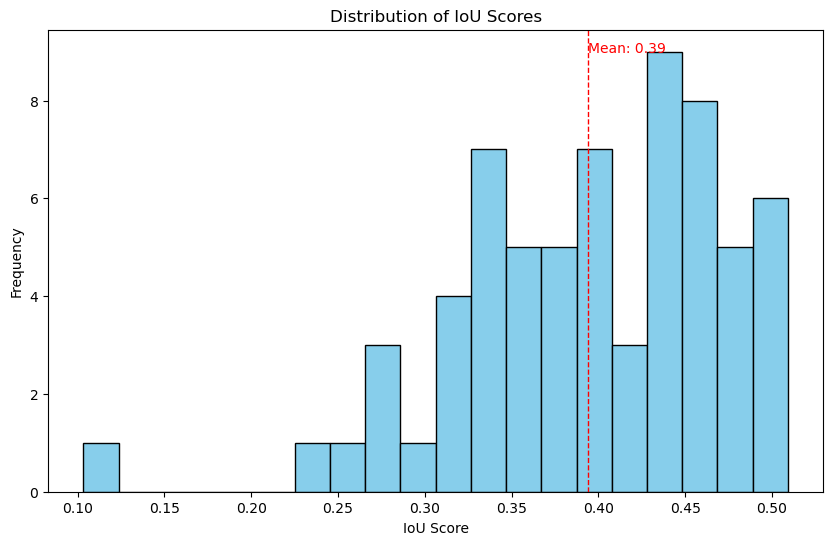

In [43]:
# Plotting the distribution of IoU scores
plt.figure(figsize=(10, 6))
plt.hist(iou_df['iou_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.axvline(mean_iou, color='red', linestyle='dashed', linewidth=1)  # Mean IoU score
plt.text(mean_iou, plt.ylim()[1]*0.95, f'Mean: {mean_iou:.2f}', color='red')
plt.show()


In [44]:
def calculate_precision(segmentation_map, label_map):
    """
    Calculate the precision between the segmentation map and the label map.
    Args:
    - segmentation_map (np.ndarray): Binary segmentation image.
    - label_map (np.ndarray): Original pixel-wise label image.
    Returns:
    - float: Precision score.
    """
    TP = np.logical_and(segmentation_map == 1, label_map == 1).sum()
    FP = np.logical_and(segmentation_map == 1, label_map == 0).sum()
    
    if TP + FP == 0:
        return 0  # Return 0 to handle division by zero case
    precision_score = TP / (TP + FP)
    return precision_score


In [45]:
precision_scores = {}  # Dictionary to hold precision scores for each image

for image_file in features_df_valid['image_file'].unique():
    binary_segmentation_image = generate_binary_segmentation_image(features_df_valid, data_dir, image_file)
    label_image_path = os.path.join(data_dir, image_file.replace('_image.png', '_label.png'))
    label_image = imageio.v2.imread(label_image_path)
    label_image = np.where(label_image > 0, 1, 0)  # Ensure binary
    
    precision_score = calculate_precision(binary_segmentation_image, label_image)
    precision_scores[image_file] = precision_score


Mean Precision Score: 0.7217243994516337


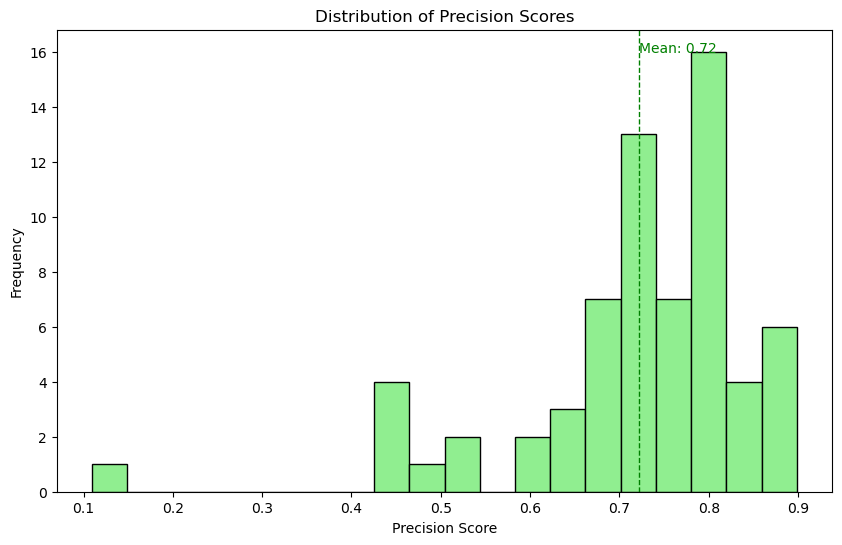

In [46]:
# Convert the precision scores dictionary to a DataFrame
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['image_file', 'precision_score'])

# Calculate the mean precision
mean_precision = precision_df['precision_score'].mean()
print(f"Mean Precision Score: {mean_precision}")

# Plot the distribution of Precision scores
plt.figure(figsize=(10, 6))
plt.hist(precision_df['precision_score'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Precision Scores')
plt.xlabel('Precision Score')
plt.ylabel('Frequency')
plt.axvline(mean_precision, color='green', linestyle='dashed', linewidth=1)
plt.text(mean_precision, plt.ylim()[1]*0.95, f'Mean: {mean_precision:.2f}', color='green')
plt.show()


In [50]:
iou_scores_test = {}  # Dictionary to hold IoU scores for each image

for image_file in features_df_test['image_file'].unique():
    # Generate the binary segmentation image for the current validation image
    binary_segmentation_image = generate_binary_segmentation_image(features_df_valid, data_dir, image_file)

    # Load the corresponding ground truth label image
    label_image_path = os.path.join(data_dir, image_file.replace('_image.png', '_label.png'))
    label_image = imageio.v2.imread(label_image_path)
    
    # Ensure label_image is binary (0 for background, 1 for object)
    label_image = np.where(label_image > 0, 1, 0)

    # Calculate IoU score
    iou_score = calculate_iou(binary_segmentation_image, label_image)
    
    # Store the IoU score
    iou_scores_test[image_file] = iou_score

In [51]:
# Convert the IoU scores dictionary to a DataFrame
iou_df_test = pd.DataFrame(list(iou_scores.items()), columns=['image_file', 'iou_score'])

# Display the first few rows to verify
print(iou_df_test.head())

mean_iou_test = iou_df_test['iou_score'].mean()
print(f"Mean IoU Score: {mean_iou}")

                                          image_file  iou_score
0  541_Hamilton_(2016-2017)_175.21236577869794,-3...        0.0
1  025_Hamilton_(2016-2017)_175.25577397537282,-3...        0.0
2  381_Hamilton_(2016-2017)_175.18618455155033,-3...        0.0
3  045_Hamilton_(2016-2017)_175.23577526166258,-3...        0.0
4  202_Hamilton_(2016-2017)_175.19977907758818,-3...        0.0
Mean IoU Score: 0.0


In [52]:
precision_scores = {}  # Dictionary to hold precision scores for each image

for image_file in features_df_test['image_file'].unique():
    binary_segmentation_image = generate_binary_segmentation_image(features_df_valid, data_dir, image_file)
    label_image_path = os.path.join(data_dir, image_file.replace('_image.png', '_label.png'))
    label_image = imageio.v2.imread(label_image_path)
    label_image = np.where(label_image > 0, 1, 0)  # Ensure binary
    
    precision_score = calculate_precision(binary_segmentation_image, label_image)
    precision_scores[image_file] = precision_score


Mean Precision Score: 0.0


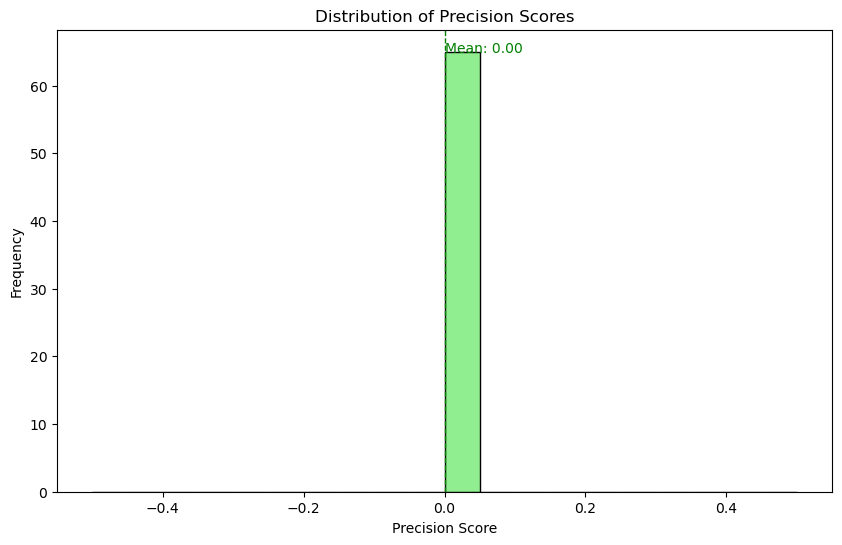

In [53]:
# Convert the precision scores dictionary to a DataFrame
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['image_file', 'precision_score'])

# Calculate the mean precision
mean_precision = precision_df['precision_score'].mean()
print(f"Mean Precision Score: {mean_precision}")

# Plot the distribution of Precision scores
plt.figure(figsize=(10, 6))
plt.hist(precision_df['precision_score'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Precision Scores')
plt.xlabel('Precision Score')
plt.ylabel('Frequency')
plt.axvline(mean_precision, color='green', linestyle='dashed', linewidth=1)
plt.text(mean_precision, plt.ylim()[1]*0.95, f'Mean: {mean_precision:.2f}', color='green')
plt.show()
